In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from prettytable import PrettyTable

C:\Users\Karl Zhang\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Karl Zhang\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Karl Zhang\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<br>
Firstly, read the pairing dataset, only keep the names of food & wines, and their taste features.

In [2]:
df = pd.read_csv('pairing_food_final.csv')
columns_taste = ['Pairing Food', 'name_pair', 'sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness', 'sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food']
df_taste = df.loc[:, columns_taste]
df_taste.head(1)

,Pairing Food,name_pair,sweetness,acidity,piquancy,fattiness,bitterness,sweetness_food,acidity_food,salinity_food,piquancy_food,fattiness_food,bitterness_food
0,beef and venison,Bordeaux Blend Red Chateau Mouton Rothschild P...,-27.316847,-0.000972,-5.65303,-4.383264,-10.966054,0.141897,0.318145,0.655264,0.473096,0.420863,0.228206


<br>
Apply some basic EDA, firstly, there shows no null values in the tastes features, good.

In [3]:
df_taste.isna().sum()

Pairing Food       0
name_pair          0
sweetness          0
acidity            0
piquancy           0
fattiness          0
bitterness         0
sweetness_food     0
acidity_food       0
salinity_food      0
piquancy_food      0
fattiness_food     0
bitterness_food    0
dtype: int64

<br>
Then, check the distribution of the tastes features. With Roald's method of food features extraction, tastes features of food shows good distribution. However, tastes features of wines are really awful as their Q1, Q2, Q3 are mostly the same, which means there exist many same values in these features.

In [4]:
df_taste.describe()

,sweetness,acidity,piquancy,fattiness,bitterness,sweetness_food,acidity_food,salinity_food,piquancy_food,fattiness_food,bitterness_food
count,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000,9747.000000
mean,-0.269340,-0.572159,-1.122507,0.615890,-2.819392,0.405325,0.493997,0.647601,0.550990,0.537180,0.413934
std,16.314167,16.242193,15.669770,18.416241,15.680012,0.269025,0.143926,0.215015,0.155203,0.200176,0.176753
min,-27.316847,-3.860968,-5.679004,-4.400361,-10.984265,0.006519,0.148080,0.287492,0.320373,0.253903,0.061735
25%,-0.000151,-3.860945,-5.653030,-4.383264,-10.966054,0.276137,0.449720,0.431853,0.429155,0.383053,0.326453
50%,-0.000151,-3.860945,-5.653030,-4.383264,-10.966054,0.356151,0.489548,0.655264,0.544681,0.515151,0.440083
75%,-0.000151,-0.000972,-5.653030,-4.383264,-10.966054,0.447529,0.570953,0.823910,0.636063,0.663687,0.553515
max,44.017020,186.186600,53.092190,68.468850,27.357250,1.000000,0.759665,1.000000,1.000000,0.983158,0.733272


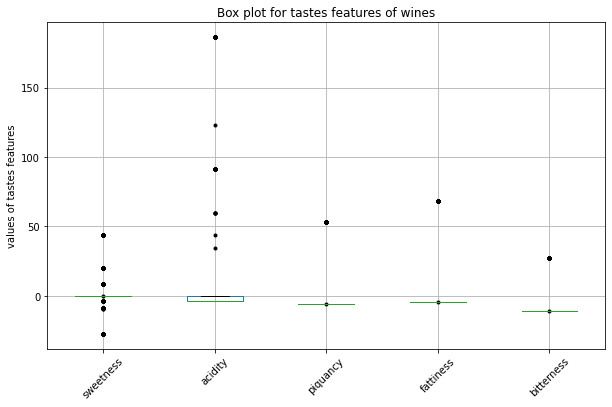

In [5]:
plt.figure(figsize=(10, 6))

columns_to_plot = ['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness']

df_taste[columns_to_plot].boxplot(sym='k.')
plt.title('Box plot for tastes features of wines') 
plt.ylabel('values of tastes features') 
plt.xticks(rotation=45)

plt.show()

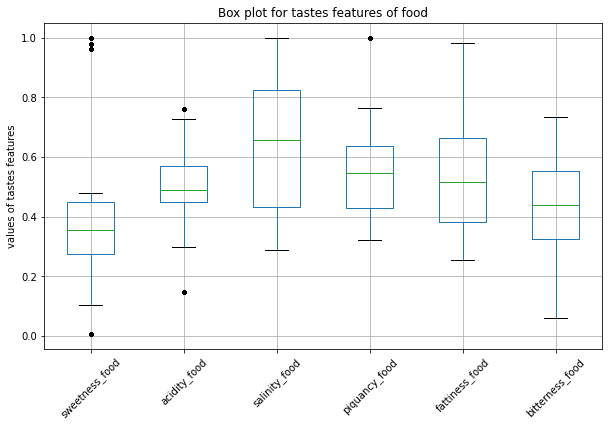

In [6]:
plt.figure(figsize=(10, 6)) 

columns_to_plot = ['sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food']

df_taste[columns_to_plot].boxplot(sym='k.')
plt.title('Box plot for tastes features of food') 
plt.ylabel('values of tastes features') 
plt.xticks(rotation=45)

plt.show()

<br>
Therefore, here I use DBSCAN to cluster each record in the dataset to make a new feature for wines, hopefully this would add more distinction between each record.

In [7]:
input_features = df_taste[['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness']]

scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features)

dbscan = DBSCAN(eps=0.5, min_samples=100)

df_taste['dbscan_cluster'] = dbscan.fit_predict(input_features_scaled)

cluster_labels = df_taste['dbscan_cluster'].unique()
for label in cluster_labels:
    cluster_data = df_taste[df_taste['dbscan_cluster'] == label]
    print(f'Cluster {label}: {len(cluster_data)} data points')

Cluster 0: 975 data points
Cluster 1: 4863 data points
Cluster 2: 1355 data points
Cluster 3: 413 data points
Cluster 4: 487 data points
Cluster 5: 282 data points
Cluster -1: 503 data points
Cluster 6: 590 data points
Cluster 7: 179 data points
Cluster 8: 100 data points


<br>
Drop all records in cluster -1, which are noises.

In [8]:
df_taste = df_taste[df_taste['dbscan_cluster'] != -1]

<br>
Then, scale the wine tastes features from 0 to 1, that would be the same scale as the food tastes features.

In [9]:
numeric_features = df_taste.columns[2:7]
scaler = MinMaxScaler()
df_taste[numeric_features] = scaler.fit_transform(df_taste[numeric_features])

In [10]:
df_taste.describe()

,sweetness,acidity,piquancy,fattiness,bitterness,sweetness_food,acidity_food,salinity_food,piquancy_food,fattiness_food,bitterness_food,dbscan_cluster
count,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000,9244.000000
mean,0.376598,0.463083,0.064430,0.052893,0.207645,0.406760,0.493628,0.647248,0.550070,0.538116,0.414166,1.921571
std,0.219917,0.497977,0.244636,0.223308,0.405178,0.271228,0.143978,0.215343,0.153894,0.199799,0.177211,1.834908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.006519,0.148080,0.287492,0.320373,0.253903,0.061735,0.000000
25%,0.382941,0.000006,0.000442,0.000235,0.000475,0.276137,0.449720,0.431853,0.429155,0.383053,0.326453,1.000000
50%,0.382941,0.000006,0.000442,0.000235,0.000475,0.356151,0.489548,0.655264,0.544681,0.515151,0.440083,1.000000
75%,0.382941,0.998532,0.000442,0.000235,0.000475,0.447529,0.570953,0.823910,0.636063,0.663687,0.553515,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.759665,1.000000,1.000000,0.983158,0.733272,8.000000


<br>
Apply the pairing ruls from wine experts, this may adjust the dataset more patterned.

In [11]:
df_taste = df_taste.loc[df_taste['sweetness'] >= df_taste['sweetness_food']]
#df_taste = df_taste.loc[df_taste['acidity'] >= df_taste['acidity_food']]
df_taste = df_taste.loc[(df_taste['bitterness'] >= 2 * df_taste['bitterness_food']) | (2 * df_taste['bitterness'] <= df_taste['bitterness_food'])]
df_taste = df_taste.loc[(df_taste['acidity'] >= 2 * df_taste['bitterness_food']) | (2 * df_taste['acidity'] <= df_taste['bitterness_food'])]
df_taste = df_taste.loc[(df_taste['bitterness'] >= 2 * df_taste['acidity_food']) | (2 * df_taste['bitterness'] <= df_taste['acidity_food'])]
df_taste = df_taste.loc[(df_taste['acidity'] >= 2 * df_taste['piquancy_food']) | (2 * df_taste['acidity'] <= df_taste['piquancy_food'])]
df_taste = df_taste.loc[(df_taste['piquancy'] >= 2 * df_taste['acidity_food']) | (2 * df_taste['piquancy'] <= df_taste['acidity_food'])]
df_taste = df_taste.loc[(df_taste['bitterness'] >= 2 * df_taste['salinity_food']) | (2 * df_taste['bitterness'] <= df_taste['salinity_food'])]
df_taste.shape

(3083, 14)

<br>
Then drop all kinds of food that exist less than 100 times, since their data would be too little.

In [12]:
df_taste['Pairing Food'].value_counts()

lamb                            401
duck, goose and game birds      378
chicken and turkey              349
beef and venison                269
blue cheeses                    247
manchego and parmesan           211
mushrooms                       190
shellfish, crab and lobster     179
cheddar and gruyere             156
chilis and hot spicy foods      152
goats' cheese and feta          137
pork, ham and cold meats        132
meaty and oily fish             112
chocolate and caramel            50
fruit-based desserts             25
white fish                       23
cakes and cream                  17
salads and green vegetables      17
tomato-based dishes              17
root vegetables and squashes     13
brie and camembert                8
Name: Pairing Food, dtype: int64

In [13]:
df_taste = df_taste[df_taste['Pairing Food'] != 'white fish']
df_taste = df_taste[df_taste['Pairing Food'] != 'salads and green vegetables']
df_taste = df_taste[df_taste['Pairing Food'] != 'tomato-based dishes']
df_taste = df_taste[df_taste['Pairing Food'] != 'root vegetables and squashes']
df_taste = df_taste[df_taste['Pairing Food'] != 'cakes and cream']
df_taste = df_taste[df_taste['Pairing Food'] != 'fruit-based desserts']
df_taste = df_taste[df_taste['Pairing Food'] != 'brie and camembert']
df_taste = df_taste[df_taste['Pairing Food'] != 'chocolate and caramel']

<br>
Only 13 kinds of food left now.

In [14]:
df_taste['Pairing Food'].nunique()

13

<br>
Now it's time to create two dataframes, one is for classification and the other one is for regression.

In [15]:
columns_classification = ['Pairing Food', 'name_pair', 'sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness', 'dbscan_cluster']
columns_regression = ['Pairing Food', 'name_pair', 'sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness', 'sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food']
df_classification = df_taste.loc[:, columns_classification]
df_regression = df_taste.loc[:, columns_regression]

# Classification
Let's classify first.

In [16]:
df_classification.head()

,Pairing Food,name_pair,sweetness,acidity,piquancy,fattiness,bitterness,dbscan_cluster
1,beef and venison,Bordeaux Blend Red Chateau Lafite Rothschild P...,0.382941,0.998532,0.000442,0.000235,0.000475,1
3,beef and venison,Cabernet Franc - Cabernet Sauvignon Tenuta San...,0.382941,0.000006,0.999605,0.000235,0.000475,3
4,beef and venison,Bordeaux Blend Red Chateau Margaux Margaux France,0.382941,0.000006,0.000442,0.000235,0.000475,1
5,beef and venison,Bordeaux Blend Red Opus One Napa Valley USA,0.382941,0.998532,0.000442,0.000235,0.000475,1
6,beef and venison,Cabernet Sauvignon - Merlot Chateau Latour Pau...,0.382941,0.000006,0.000442,0.000235,0.000475,1


In [17]:
df_classification.describe()

,sweetness,acidity,piquancy,fattiness,bitterness,dbscan_cluster
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,0.427517,0.260178,0.056351,0.061998,0.082825,1.786131
std,0.160045,0.438367,0.229684,0.240706,0.274872,1.589561
min,0.256977,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.382941,0.000006,0.000442,0.000235,0.000475,1.000000
50%,0.382941,0.000006,0.000442,0.000235,0.000475,1.000000
75%,0.382941,0.998532,0.000442,0.000235,0.000475,2.000000
max,1.000000,1.000000,0.999605,0.999767,1.000000,8.000000


<br>
Simply encode 'Pairing Food' with LabelEncoder().

In [18]:
# df_classification = pd.get_dummies(df_classification, columns=['Pairing Food'])
label_encoder = LabelEncoder()
label_encoder.fit(df_classification['Pairing Food'])
df_classification['Pairing Food Encoded'] = label_encoder.transform(df_classification['Pairing Food'])

In [19]:
df_classification.head()

,Pairing Food,name_pair,sweetness,acidity,piquancy,fattiness,bitterness,dbscan_cluster,Pairing Food Encoded
1,beef and venison,Bordeaux Blend Red Chateau Lafite Rothschild P...,0.382941,0.998532,0.000442,0.000235,0.000475,1,0
3,beef and venison,Cabernet Franc - Cabernet Sauvignon Tenuta San...,0.382941,0.000006,0.999605,0.000235,0.000475,3,0
4,beef and venison,Bordeaux Blend Red Chateau Margaux Margaux France,0.382941,0.000006,0.000442,0.000235,0.000475,1,0
5,beef and venison,Bordeaux Blend Red Opus One Napa Valley USA,0.382941,0.998532,0.000442,0.000235,0.000475,1,0
6,beef and venison,Cabernet Sauvignon - Merlot Chateau Latour Pau...,0.382941,0.000006,0.000442,0.000235,0.000475,1,0


<br>
Split training / test sets.

In [20]:
X = df_classification[['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness', 'dbscan_cluster']]
y = df_classification[['Pairing Food Encoded']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<br>
I met some problem with my jupyter notebook environment, thus saving these files and train models in another environment using IDE.

In [21]:
X_train.to_csv('X_train.csv', index=False)

X_test.to_csv('X_test.csv', index=False)

y_train.to_csv('y_train.csv', index=False)  

y_test.to_csv('y_test.csv', index=False)  

<br>
I use ensemble learning here with combination of Random Forest, Gradient Boosting, and AdaBoost.

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

gb_classifier = GradientBoostingClassifier(n_estimators=1000, learning_rate=1, max_depth=10, random_state=42)

adaboost_classifier = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=42)

# create ensemble learning model with voting
voting_classifier = VotingClassifier(estimators=[
    ('Random Forest', rf_classifier),
    ('Gradient Boosting', gb_classifier),
    ('AdaBoost', adaboost_classifier)
], voting='soft')

voting_classifier.fit(X_train, y_train.values.ravel())

y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

report = classification_report(y_test, y_pred)
print(report)

0.2538593481989708
              precision    recall  f1-score   support

           0       0.29      0.69      0.41        55
           1       0.45      0.38      0.41        60
           2       0.00      0.00      0.00        31
           3       0.64      0.14      0.23        63
           4       0.26      0.35      0.30        26
           5       0.46      0.07      0.13        81
           6       0.00      0.00      0.00        18
           7       0.58      0.23      0.32        80
           8       0.14      0.80      0.24        51
           9       0.00      0.00      0.00        30
          10       0.17      0.14      0.16        28
          11       0.00      0.00      0.00        25
          12       0.00      0.00      0.00        35

    accuracy                           0.25       583
   macro avg       0.23      0.22      0.17       583
weighted avg       0.32      0.25      0.21       583



C:\Users\Karl Zhang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Karl Zhang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Karl Zhang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<br>
ROC and AUC for each category.

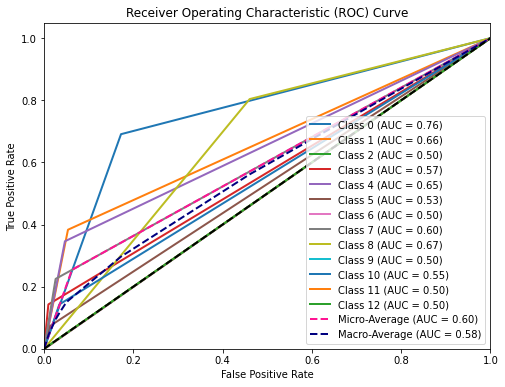

In [23]:
y_test = label_binarize(y_test, classes=range(13))
y_pred = label_binarize(y_pred, classes=range(13))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(13):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(13)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(13):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 13
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
for i in range(13):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-Average (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle='--', lw=2)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-Average (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle='--', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<br>
Learning curve of the classifier:

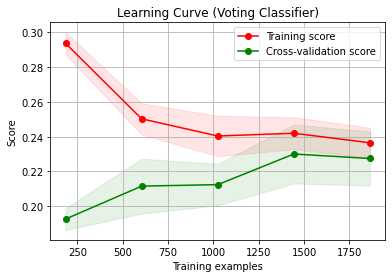

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(voting_classifier, "Learning Curve (Voting Classifier)", X_train, y_train.values.ravel(), cv=5)

plt.show()

# Regressor
Despite the problems with the classifier, I symbolically build a regressor here to show the possible function of predicting the taste vector of a specific food based on the input wine.

In [25]:
df_regression.head(1)

,Pairing Food,name_pair,sweetness,acidity,piquancy,fattiness,bitterness,sweetness_food,acidity_food,salinity_food,piquancy_food,fattiness_food,bitterness_food
1,beef and venison,Bordeaux Blend Red Chateau Lafite Rothschild P...,0.382941,0.998532,0.000442,0.000235,0.000475,0.141897,0.318145,0.655264,0.473096,0.420863,0.228206


<br>
Split training / test sets and train a randon forest regressor.

In [26]:
X_re = df_regression[['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness']]
y_re = df_regression[['sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food']]

X_re_train, X_re_test, y_re_train, y_re_test = train_test_split(X_re, y_re, test_size=0.2, random_state=42)

In [27]:
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)

rf_regressor.fit(X_re_train, y_re_train)

y_re_pred = rf_regressor.predict(X_re_test)

mse = mean_squared_error(y_re_test, y_re_pred)
r2 = r2_score(y_re_test, y_re_pred)

print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error: 0.017735338633084432
R-squared (R2) Score: 0.32509071647307636


<br>
Learning curve of the regressor:

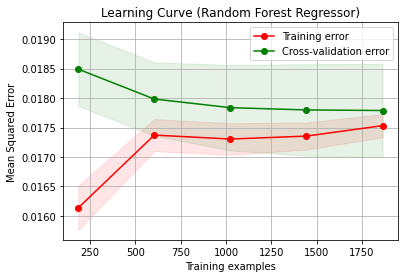

In [28]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation error")

    plt.legend(loc="best")
    return plt

plot_learning_curve(rf_regressor, "Learning Curve (Random Forest Regressor)", X_re_train, y_re_train, cv=5, n_jobs=-1)
plt.show()

# How to use?
For example, we now have a bottle of wine which is shown in the 1st line of the dataset, then it's name should be:

In [29]:
df_classification['name_pair'].iloc[0]

'Bordeaux Blend Red Chateau Lafite Rothschild Pauillac France'

<br>
Use the pre-trained voting_classifier and get y_use = 0, which represents beef and venison.

In [30]:
X_use = df_classification[['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness', 'dbscan_cluster']].head(1)
X_use

,sweetness,acidity,piquancy,fattiness,bitterness,dbscan_cluster
1,0.382941,0.998532,0.000442,0.000235,0.000475,1


In [31]:
y_use = voting_classifier.predict(X_use)
y_use

array([0])

<br>
Similarly, apply the pre-trained regressor.

In [32]:
X_re_use = df_regression[['sweetness', 'acidity', 'piquancy', 'fattiness', 'bitterness']].head(1)
X_re_use

,sweetness,acidity,piquancy,fattiness,bitterness
1,0.382941,0.998532,0.000442,0.000235,0.000475


In [33]:
y_re_use = rf_regressor.predict(X_re_use)
y_re_use

array([[0.10203317, 0.27231234, 0.52522591, 0.4192189 , 0.36747407,
        0.15657317]])

<br>
Compare to the true features of the pairing food.

In [34]:
df_regression[['sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food']].head(1)

,sweetness_food,acidity_food,salinity_food,piquancy_food,fattiness_food,bitterness_food
1,0.141897,0.318145,0.655264,0.473096,0.420863,0.228206


<br>
Scale from 0 to 10 and visualize

In [35]:
scaled_data = np.round(y_re_use * 10, 1)
scaled_data

array([[1. , 2.7, 5.3, 4.2, 3.7, 1.6]])

C:\Users\KARLZH~1\AppData\Local\Temp/ipykernel_4924/2313917341.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(angles,data,'bo-',color ='g',linewidth=2)


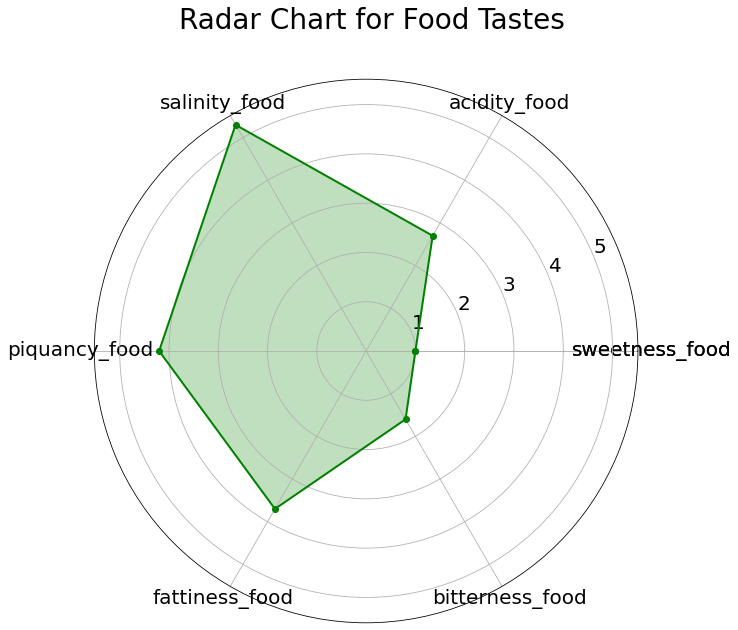

In [36]:
labels = np.array(['sweetness_food', 'acidity_food', 'salinity_food', 'piquancy_food', 'fattiness_food', 'bitterness_food'])
dataLenth  = 6      
data = np.array(scaled_data[0])
angles = np.linspace(0,2*np.pi,dataLenth,endpoint=False)   
 
data = np.concatenate((data,[data[0]])) 
angles = np.concatenate((angles,[angles[0]]))
labels=np.concatenate((labels,[labels[0]]))  
plt.rc('font', size=20) 

fig = plt.figure(figsize=(10, 10), facecolor="white")    
plt.subplot(111,polar=True)    
plt.plot(angles,data,'bo-',color ='g',linewidth=2)
plt.fill(angles,data,facecolor='g',alpha=0.25)    
plt.thetagrids(angles*180/np.pi,labels)          
plt.figtext(0.52,0.95,'Radar Chart for Food Tastes',ha='center', fontsize=28)  
plt.grid(True)
plt.show()